# Document AI: Fine-tuning LiLT for document-understanding using Hugging Face Transformers 
_Document AI: LiLT a better language agnostic LayoutLM model_ 

In this blog, you will learn how to fine-tune [LiLt](https://huggingface.co/docs/transformers/v4.24.0/en/model_doc/lilt#lilt) for document-understand using Hugging Face Transformers. LiLt or **L**anguage **i**ndependent **L**ayout **T**ransformer can combine any pre-trained [RoBERTa](https://huggingface.co/models?other=roberta) text encoder with a lightweight Layout Transformer, to enable document understanding and information extraction for any language. 
This means you can use non-English RoBERTa checkpoints, e.g. [bertin-project/bertin-roberta-base-spanish](https://huggingface.co/bertin-project/bertin-roberta-base-spanish) for document understanding tasks. To convert a RoBERTa checkpoint to a LiLT checkpoint, you can follow [this guide](https://github.com/jpWang/LiLT#or-generate-your-own-checkpoint-optional).
[LiLt](https://huggingface.co/docs/transformers/v4.24.0/en/model_doc/lilt#lilt) is released with an MIT license and is available on the [Hugging Face Hub](https://huggingface.co/models?other=lilt). 

In this example we will use the [FUNSD](https://guillaumejaume.github.io/FUNSD/) dataset a collection of 199 fully annotated forms. More information for the dataset can be found at the [dataset page](https://guillaumejaume.github.io/FUNSD/).

You will learn how to:

1. [Setup Development Environment](#1-setup-development-environment)
2. [Load and prepare FUNSD dataset](#2-load-sroie-dataset)
3. [Fine-tune and evaluate LiLT](#4-fine-tune-and-evaluate-lilt-model)

Before we can start, make sure you have a [Hugging Face Account](https://huggingface.co/join) to save artifacts and experiments. 

## Quick intro: LiLT Language-independent Layout Transformer 

LiLT is a language independent Transformer model for document image understanding and information extraction transformers and can be used form understanding and receipt understanding. LiLT can be pretrained on the structured documents of a single language and then directly fine-tuned on other languages with the corresponding offthe-shelf monolingual/multilingual pre-trained textual models. 

![lilt](../assets/lilt.png)

* Paper: https://arxiv.org/abs/2202.13669
* Official repo: https://github.com/jpwang/lilt

--- 

Now we know how LiLT works, let's get started. 🚀

_Note: This tutorial was created and run on a g4dn.xlarge AWS EC2 Instance including a NVIDIA T4._



## 1. Setup Development Environment

Our first step is to install the Hugging Face Libraries, including transformers and datasets. Running the following cell will install all the required packages. 
Additinoally, we need to install an OCR-library to extract text from images. We will use [pytesseract](https://pypi.org/project/pytesseract/).

In [ ]:
# ubuntu
!sudo apt install -y tesseract-ocr
# python
!pip install pytesseract transformers datasets seqeval tensorboard --upgrade

In [ ]:
# install git-fls for pushing model and logs to the hugging face hub
!sudo apt-get install git-lfs --yes

This example will use the [Hugging Face Hub](https://huggingface.co/models) as a remote model versioning service. To be able to push our model to the Hub, you need to register on the [Hugging Face](https://huggingface.co/join). 
If you already have an account, you can skip this step. 
After you have an account, we will use the `notebook_login` util from the `huggingface_hub` package to log into our account and store our token (access key) on the disk. 

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## 2. Load and prepare FUNSD dataset

We will use the [FUNSD](https://guillaumejaume.github.io/FUNSD/) dataset a collection of 199 fully annotated forms. The dataset is available on Hugging Face at [nielsr/funsd](https://huggingface.co/datasets/nielsr/funsd). 

In [1]:
dataset_id ="nielsr/funsd"

To load the `funsd` dataset, we use the `load_dataset()` method from the 🤗 Datasets library.


In [2]:
from datasets import load_dataset


dataset = load_dataset(dataset_id)

print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")

Found cached dataset funsd (/home/ubuntu/.cache/huggingface/datasets/nielsr___funsd/funsd/1.0.0/8b0472b536a2dcb975d59a4fb9d6fea4e6a1abe260b7fed6f75301e168cbe595)


  0%|          | 0/2 [00:00<?, ?it/s]

Train dataset size: 149
Test dataset size: 50


Lets checkout an example of the dataset.

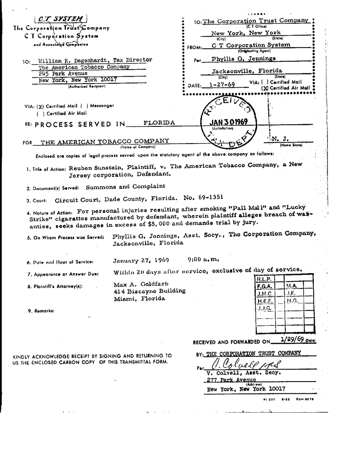

In [3]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open(dataset['train'][34]['image_path'])
image = image.convert("RGB")
image.resize((350,450))

We can display all our classes by inspecting the features of our dataset. Those `ner_tags` will be later used to create a user friendly output after we fine-tuned our model.

In [4]:
labels = dataset['train'].features['ner_tags'].feature.names
print(f"Available labels: {labels}")

id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}

Available labels: ['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']


To train our model we need to convert our inputs (text/image) to token IDs. This is done by a 🤗 Transformers Tokenizer and PyTesseract. If you are not sure what this means check out [chapter 6](https://huggingface.co/course/chapter6/1?fw=tf) of the Hugging Face Course.

_Note: The LiLT model doesn't have a `AutoProcessor` or `Tokenizer` to nicely create our input documents, but we can use the `LayoutLMv3Processor` or `LayoutLMv2Processor` instead._  

In [5]:
from transformers import LayoutLMv3FeatureExtractor, AutoTokenizer, LayoutLMv3Processor

model_id="SCUT-DLVCLab/lilt-roberta-en-base"

# use LayoutLMv3 processor without ocr since the dataset already includes the ocr text
feature_extractor = LayoutLMv3FeatureExtractor(apply_ocr=False) # set 
tokenizer = AutoTokenizer.from_pretrained(model_id)
# cannot use from_pretrained since the processor is not saved in the base model
processor = LayoutLMv3Processor(feature_extractor, tokenizer)

Before we can process our dataset we need to define the `features` or the processed inputs, which are later based into the model. Features are a special dictionary that defines the internal structure of a dataset.
Compared to traditional NLP datasets we need to add the `bbox` feature, which is a 2D array of the bounding boxes for each token. 

In [6]:
from PIL import Image
from functools import partial
from datasets import Features, Sequence, ClassLabel, Value, Array2D


# we need to define custom features
features = Features(
    {
        "input_ids": Sequence(feature=Value(dtype="int64")),
        "attention_mask": Sequence(feature=Value(dtype="int64")),
        "bbox": Array2D(dtype="int64", shape=(512, 4)),
        "labels": Sequence(ClassLabel(names=labels)),
    }
)

# preprocess function to perpare into the correct format for the model
def process(sample, processor=None):
    encoding = processor(
        Image.open(sample["image_path"]).convert("RGB"),
        sample["words"],
        boxes=sample["bboxes"],
        word_labels=sample["ner_tags"],
        padding="max_length",
        truncation=True,
    )
    # remove pixel values not needed for LiLT
    del encoding["pixel_values"]
    return encoding


# process the dataset and format it to pytorch
proc_dataset = dataset.map(
    partial(process, processor=processor),
    remove_columns=["image_path", "words", "ner_tags", "id", "bboxes"],
    features=features,
).with_format("torch")

print(proc_dataset["train"].features.keys())
# dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox','lables'])


  0%|          | 0/149 [00:00<?, ?ex/s]

Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/nielsr___funsd/funsd/1.0.0/8b0472b536a2dcb975d59a4fb9d6fea4e6a1abe260b7fed6f75301e168cbe595/cache-5f50bd5ed7b50181.arrow


dict_keys(['input_ids', 'attention_mask', 'bbox', 'labels'])


## 3. Fine-tune and evaluate LiLT

After we have processed our dataset, we can start training our model. Therefore we first need to load the [SCUT-DLVCLab/lilt-roberta-en-base](SCUT-DLVCLab/lilt-roberta-en-base) model, which is based on a English RoBERTa model with the `LiltForTokenClassification` class with the label mapping of our dataset. 



In [7]:
from transformers import LiltForTokenClassification

# huggingface hub model id
model_id = "SCUT-DLVCLab/lilt-roberta-en-base"

# load model with correct number of labels and mapping
model = LiltForTokenClassification.from_pretrained(
    model_id, num_labels=len(labels), label2id=label2id, id2label=id2label
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Some weights of LiltForTokenClassification were not initialized from the model checkpoint at SCUT-DLVCLab/lilt-roberta-en-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We want to evaluate our model during training. The `Trainer` supports evaluation during training by providing a `compute_metrics`. 
We are going to use `seqeval` and the `evaluate` library to evaluate the overall f1 score for all tokens. 

In [8]:
import evaluate
import numpy as np

# load seqeval metric
metric = evaluate.load("seqeval")

# labels of the model
ner_labels = list(model.config.id2label.values())


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    all_predictions = []
    all_labels = []
    for prediction, label in zip(predictions, labels):
        for predicted_idx, label_idx in zip(prediction, label):
            if label_idx == -100:
                continue
            all_predictions.append(ner_labels[predicted_idx])
            all_labels.append(ner_labels[label_idx])
    return metric.compute(predictions=[all_predictions], references=[all_labels])


The last step is to define the hyperparameters (`TrainingArguments`) we want to use for our training. We are leveraging the [Hugging Face Hub](https://huggingface.co/models) integration of the `Trainer` to automatically push our checkpoints, logs and metrics during training into a repository.

In [ ]:
from huggingface_hub import HfFolder
from transformers import Trainer, TrainingArguments

# hugging face parameter
repository_id = "lilt-roberta-en-base-funsd"

# Define training args
training_args = TrainingArguments(
    output_dir=repository_id,
    num_train_epochs=15,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True,
    learning_rate=3e-5,
    # logging & evaluation strategies
    logging_dir=f"{repository_id}/logs",
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="overall_f1",
    # push to hub parameters
    report_to="tensorboard",
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=repository_id,
    hub_token=HfFolder.get_token(),
)

# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=proc_dataset["train"],
    eval_dataset=proc_dataset["test"],
    compute_metrics=compute_metrics,
)

We can start our training by using the `train` method of the `Trainer`.

In [ ]:
# Start training
trainer.train()

Nice, we have trained our model. 🎉 The best score we achieved is an overall f1 score of `0.787`.

![layout_training](../assets/layout_training.png)

After our training is done we also want to save our processor to the Hugging Face Hub and create a model card. 

In [ ]:
# change apply_ocr to True to use the ocr text for inference
processor.feature_extractor.apply_ocr = True

# Save processor and create model card
processor.save_pretrained(repository_id)
trainer.create_model_card()
trainer.push_to_hub()

## 4. Run Inference

Now we have a trained model, we can use it to run inference. We will create a function that takes a document image and returns the extracted text and the bounding boxes.

In [ ]:
from transformers import LiltForTokenClassification, LayoutLMv3Processor
from PIL import Image, ImageDraw, ImageFont
import torch

# load model and processor from huggingface hub
model = LiltForTokenClassification.from_pretrained("philschmid/lilt-roberta-en-base-funsd")
processor = LayoutLMv3Processor.from_pretrained("philschmid/lilt-roberta-en-base-funsd")


# helper function to unnormalize bboxes for drawing onto the image
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]


label2color = {
    "B-HEADER": "blue",
    "B-QUESTION": "red",
    "B-ANSWER": "green",
    "I-HEADER": "blue",
    "I-QUESTION": "red",
    "I-ANSWER": "green",
}
# draw results onto the image
def draw_boxes(image, boxes, predictions):
    width, height = image.size
    normalizes_boxes = [unnormalize_box(box, width, height) for box in boxes]

    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(predictions, normalizes_boxes):
        if prediction == "O":
            continue
        draw.rectangle(box, outline="black")
        draw.rectangle(box, outline=label2color[prediction])
        draw.text((box[0] + 10, box[1] - 10), text=prediction, fill=label2color[prediction], font=font)
    return image


# run inference
def run_inference(path, model=model, processor=processor, output_image=True):
    # create model input
    image = Image.open(path).convert("RGB")
    encoding = processor(image, return_tensors="pt")
    del encoding["pixel_values"]
    # run inference
    outputs = model(**encoding)
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    # get labels
    labels = [model.config.id2label[prediction] for prediction in predictions]
    if output_image:
        return draw_boxes(image, encoding["bbox"][0], labels)
    else:
        return labels


run_inference(dataset["test"][34]["image_path"])


## Conclusion

We managed to successfully fine-tune our LayoutLM to extract information from forms. With only `149` training examples we achieved an overall f1 score of `0.86`, which is impressive and another prove for the power of transfer learning. 

Now its your time to integrate Transformers into your own projects. 🚀 